# Time Series Course

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
lynx = pd.read_csv('lynx_data.csv')
lynx.head()

,year,trappings
0,1821,269
1,1822,321
2,1823,585
3,1824,871
4,1825,1475


Text(0, 0.5, '# Trappings')

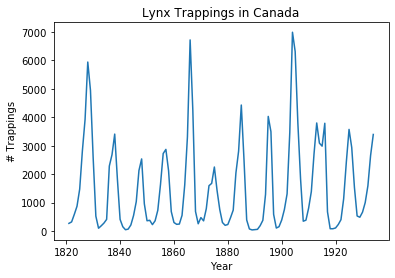

In [9]:
plt.plot(lynx['year'], lynx['trappings'])
plt.title("Lynx Trappings in Canada")
plt.xlabel("Year")
plt.ylabel("# Trappings")

seasonal pulses: peaks at every few years
Autocorrelation: previous trapped lynx is an indicator of future population